# LO 6 Plasma for E301

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from ionization import ionization
from lens import profile
from lens import design
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam import interactions
import matplotlib.pyplot as plt
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/E301/Lithium_Oven_Optic_6/'
lam = 0.796
tau = 70
# All length units are in um

Bessel beam formed using the LO6 optics for the Lithium Oven. Initial form of E301 in the bypass line.

In [2]:
loadPath = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_6/'
plasma_LO, I, z, sim_start, sim_length, pulse = design.load_plasma_design(loadPath)

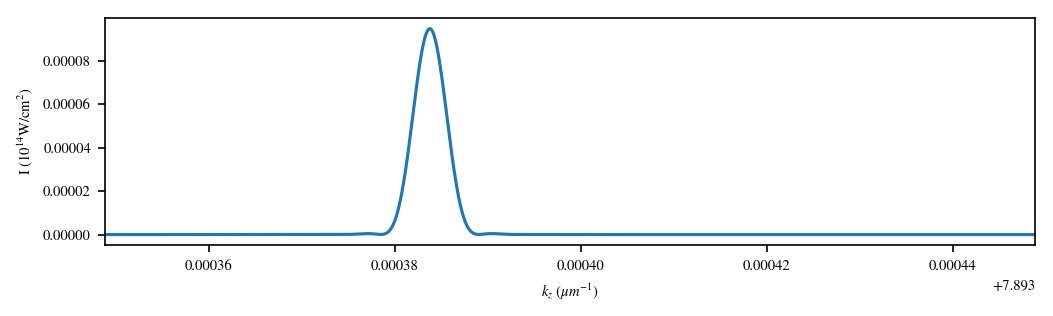

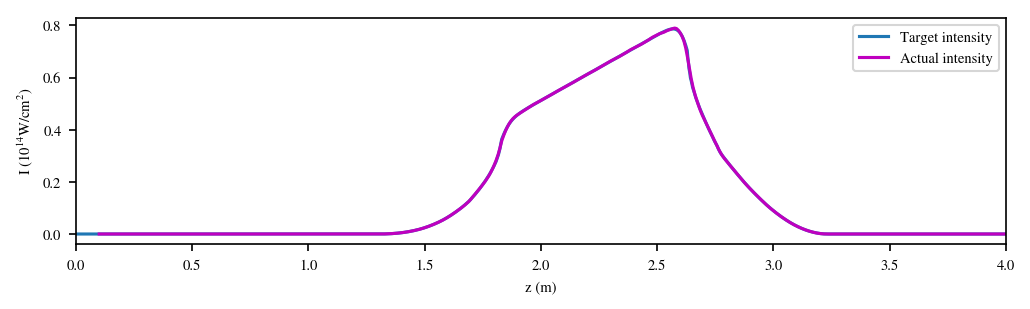

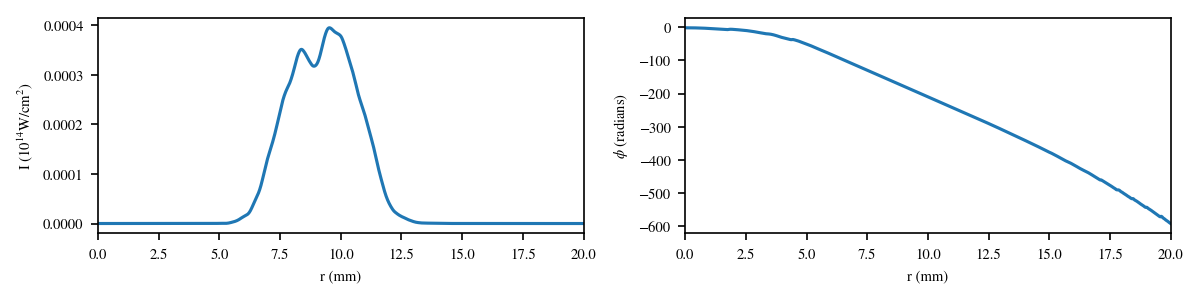

In [3]:
# Optic design upstream
width = 75
xlim = [0, 4]
z0 = 1.83075e6
z_optic, I_optic = design.extend_zI(z0, 'start', z, I, sim_start, sim_length)
I_optic *= 1
r, E = design.calculate_tran_field(z_optic, I_optic, 20e3, width, lam, path, 10e-5, xlim, [0, 20])

In [4]:
L = 0.8e6
R_max = 15e3
X = 80e3
Nx = 2**13
ri = np.linspace(0, 15e3, len(r))
Ei = np.ones(len(r))
rA, phiA, lensA, multi = design.create_lens_A(ri, Ei, r, E, L, path, lam, X, Nx)

Maximum phase change in one pixel 0.05 rad/um


Total input energy 17.74mJ


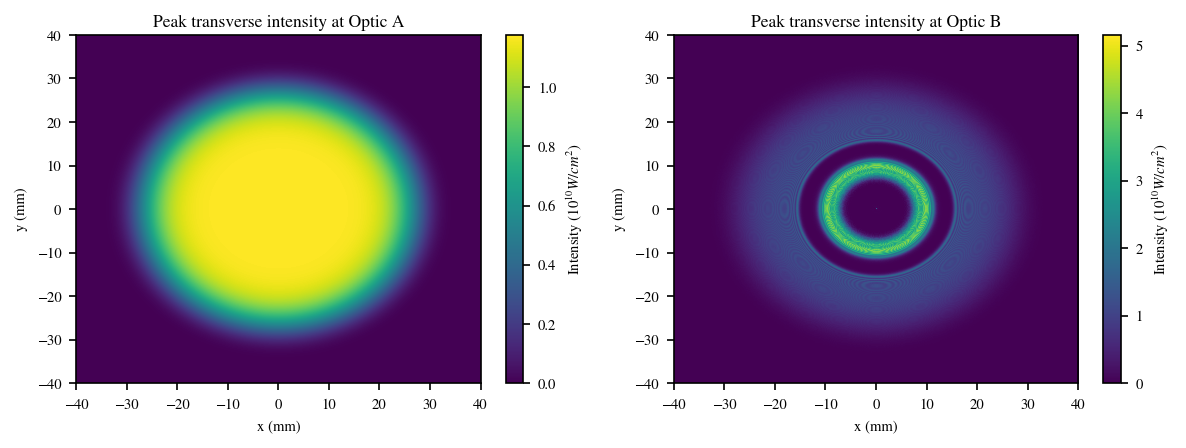

In [5]:
n = 8
w0 = 30e3
r0 = np.linspace(0, 100e3, 5000)
E0 = np.exp(-(r0/w0)**n)*multi
beam0 = design.propagate_to_lens_B(r0, E0, L, path, lam, lensA, tau, 20)

Maximum phase change in one pixel 0.30 rad/um


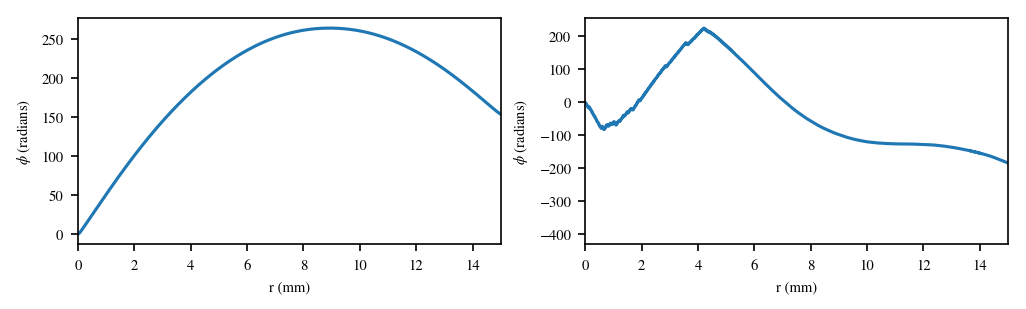

In [6]:
Nx = 2**12
X = 40e3
rB, phiB, lensB = design.create_lens_B(beam0, r, E, path, lam, X, Nx)
design.plot_phase(rA, phiA, rB, phiB, [0, 15])

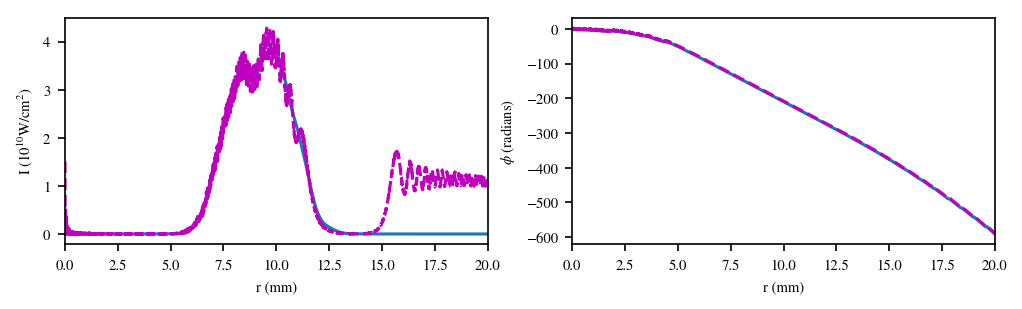

In [7]:
r1, e1 = design.field_after_lens_B(beam0, rB, phiB, r, E, [0, 20])

In [8]:
# First Optic A to Optic B
XA = lensA.X
NxA = lensA.Nx
beamParams = {'Nx' : NxA,
              'Ny' : NxA,
              'X' : XA,
              'Y' : XA,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 20,
              'cyl' : True,
              'load' : False}

# Super Gaussian for simulation
Nz0 = 400
z_ab = np.linspace(0, L, Nz0)
beam = laserbeam.Laser(beamParams)
e = beam.reconstruct_from_cyl(r0, E0, beam.x, beam.y)
beam.initialize_field(e)
I0 = ionization.intensity_from_field(E0)
print('Total input energy %0.2fmJ' % (beam.total_cyl_power(r0, I0)*tau))
interactions.beam_phase(beam, lensA)
beam.propagate(z_ab, 1.0)

Total input energy 17.74mJ


In [9]:
I_ab = np.zeros((Nz0, NxA))
for i in range(Nz0):
    I_ab[i, :] = beam.intensity_from_field(beam.load_field(i+1)[0])
I_ab = beam.prep_data(I_ab)

In [10]:
XB = 30e3
NxB = 2**13
pulseParams = {
    'Nt' : 2**6,
    'Nx' : NxB,
    'Ny' : NxB,
    'X' : XB,
    'Y' : XB,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'To_Start',
}
Z1 = z0-10e4
beam = laserbeam.Laser(pulseParams)
e = beam.reconstruct_from_cyl(r1, e1, beam.x, beam.y)
beam.initialize_field(e)
Nz1 = 400
z_bLO = np.linspace(0, Z1, Nz1)
beam.propagate(z_bLO, 1)

In [11]:
I_bLO = np.zeros((Nz1, NxB))
for i in range(Nz1):
    I_bLO[i, :] = beam.intensity_from_field(beam.load_field(i)[0])
I_bLO = beam.prep_data(I_bLO)

In [12]:
XP = 10e3
NxP = 2**11
NzP = 400
Z_p = 120e4
ne0 = 3.4e16/1e17
n = lambda z: ne0
ext = [0, Z_p/1e4, -XP/2, XP/2]
plt.style.use('presentation')
pulse, I, ne = design.plasma_refraction(XP, NxP, Z_p, NzP, beam, pulseParams, ionization.H2, n, sim_start, 20,
                                        name='Plasma_Hydrogen')

Initial pulse energy 113.73mJ
Final pulse energy 109.77mJ


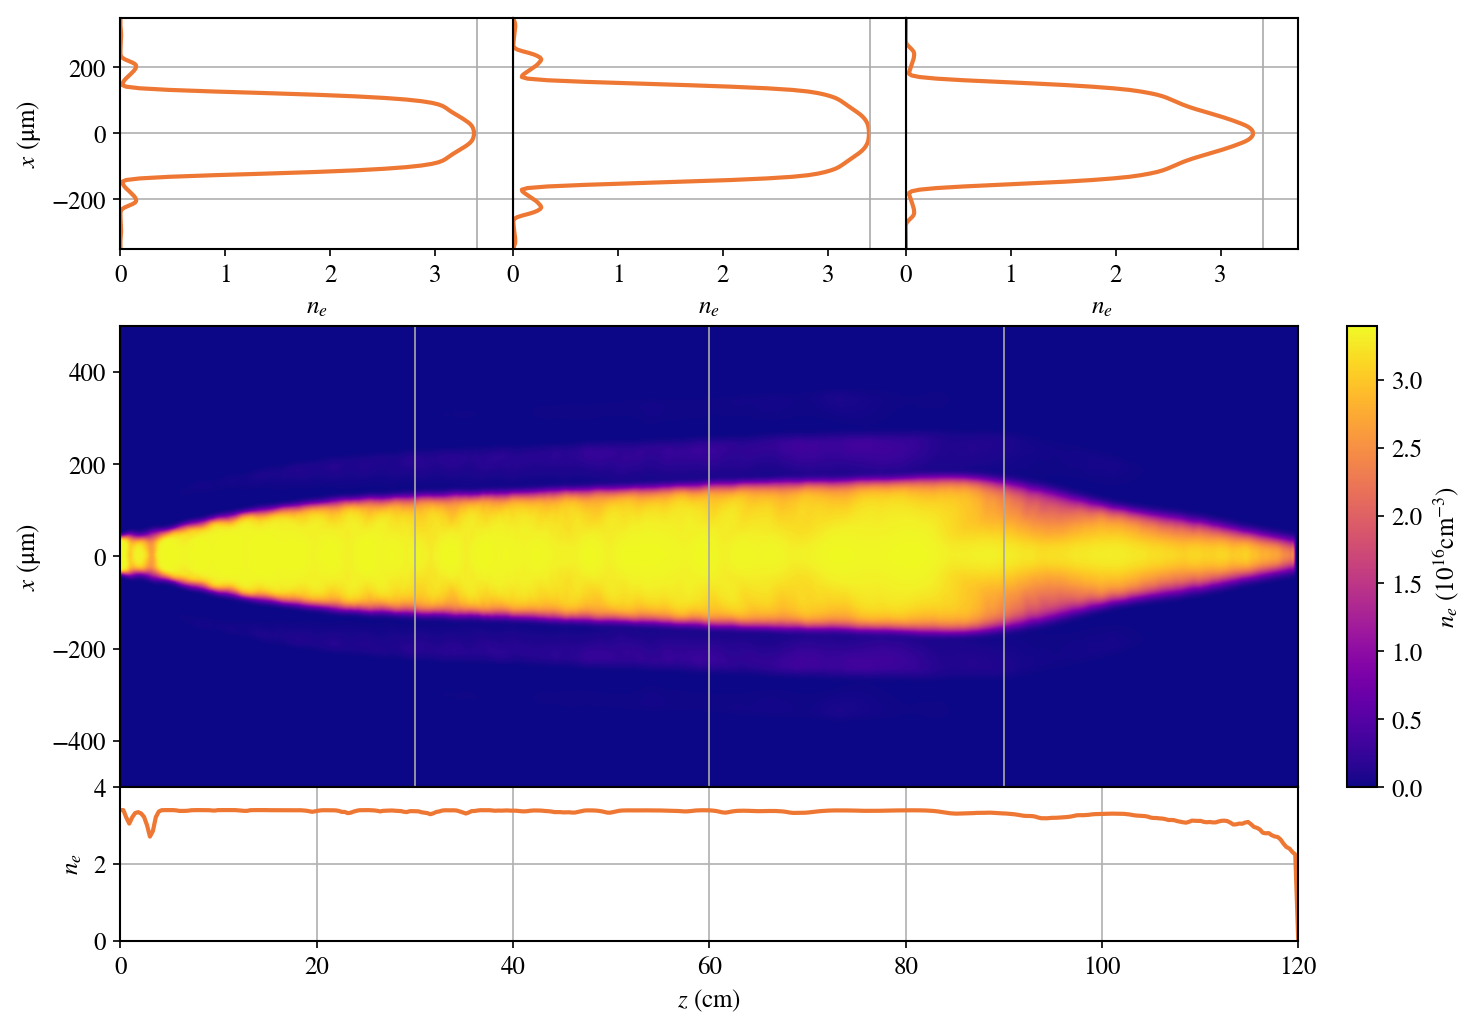

In [15]:
design.plot_plasma_density(pulse, ne, ne0, ext, lines=[30, 60, 90])

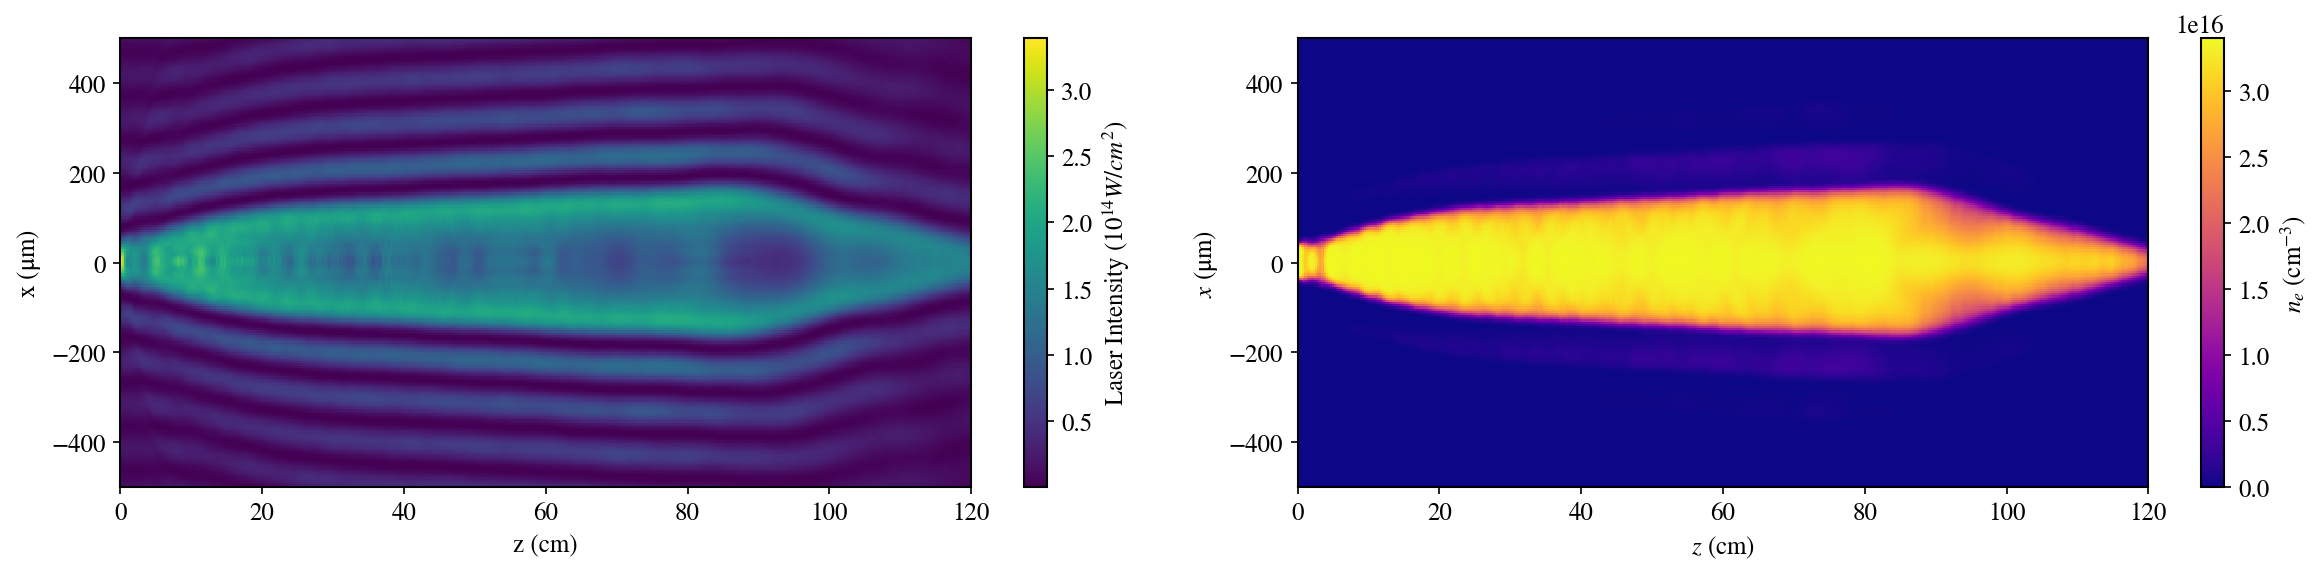

In [14]:
design.plot_laser_plasma(I, ne, ext)

In [14]:
XP = 10e3
NxP = 2**10
NzP = 400
Z_p = 120e4
ne0 = 3.4e16/1e17
n = lambda z: ne0
ext = [0, Z_p/1e4, -XP/2, XP/2]
plt.style.use('presentation')
pulse, I, ne = design.plasma_refraction(XP, NxP, Z_p, NzP, beam, pulseParams, ionization.H2, n, sim_start, 20,
                                        ne0, name='Plasma_Hydrogen_Kerr', n2=1e-19)

Initial pulse energy 113.73mJ
Final pulse energy 111.60mJ


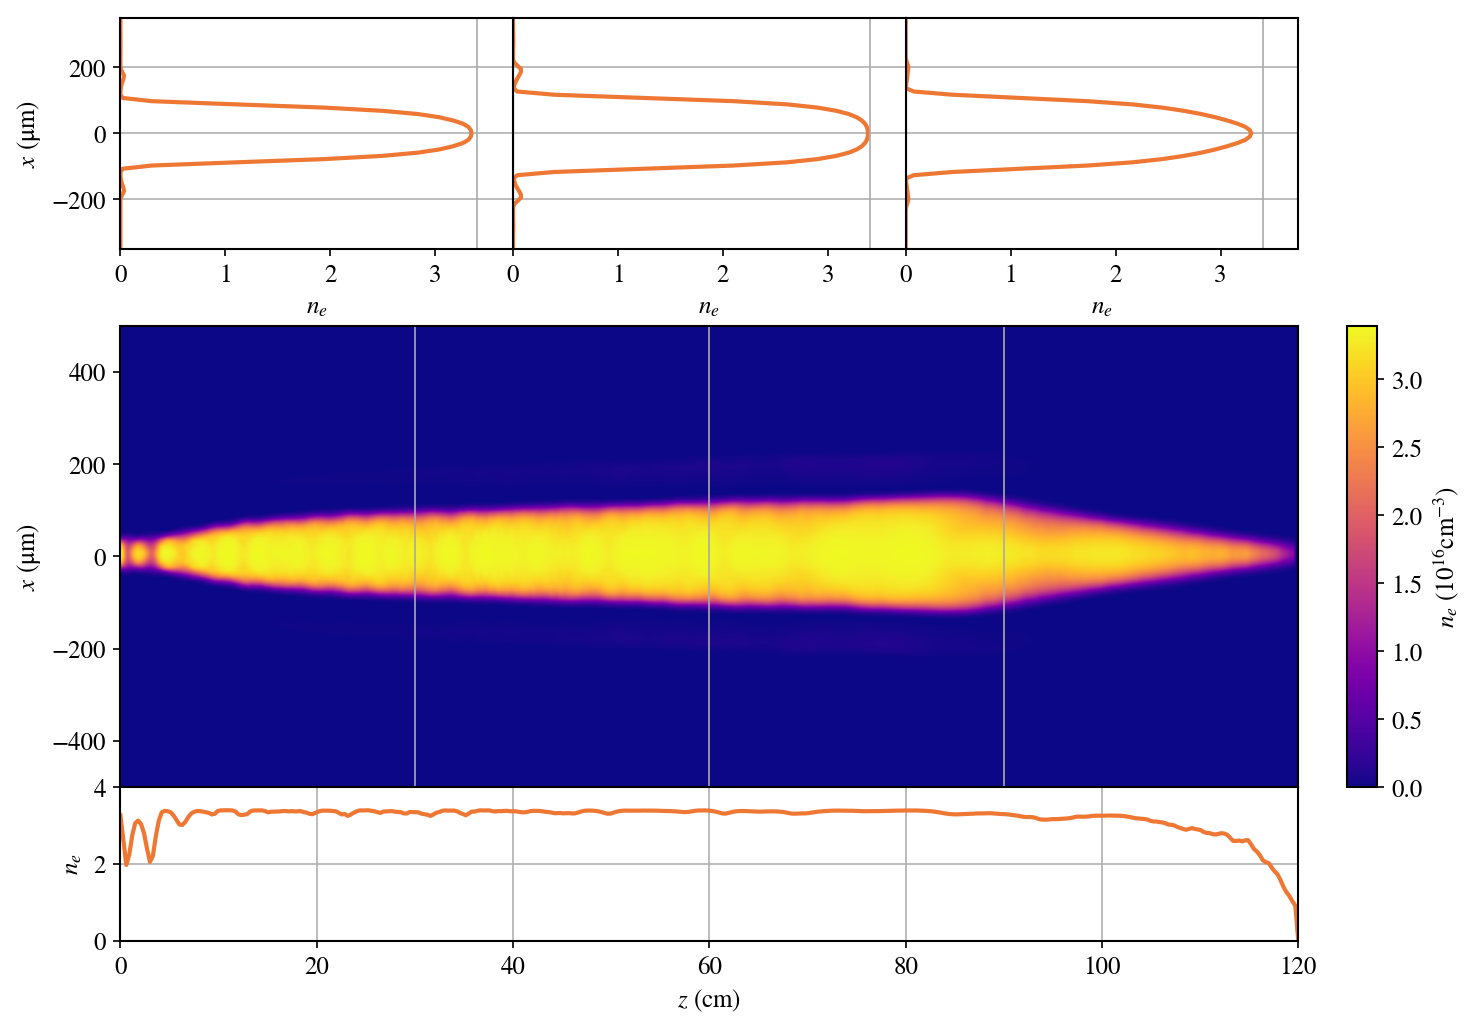

In [15]:
design.plot_plasma_density(pulse, ne, ne0, ext, lines=[30, 60, 90])